In [80]:
import torch
import torch.optim as optim
from skimage.metrics import structural_similarity as ssim,peak_signal_noise_ratio
import os
import matplotlib.pyplot as plt
import statistics
import pickle
import tifffile as tiff

import math
import cv2
import numpy as np
from numpy import cos as cos
from numpy import sin as sin
from numpy import sqrt as sqrt
from numpy import arctan2 as arctan2
from matplotlib import pyplot as plt

In [81]:
def ASM(d=20e-3, Source_PhsHolo=torch.zeros((100, 100)), Source_AmpHolo=torch.ones((100, 100)), Lam=6.4e-4, fs=1e6/320):
    assert Lam > 0, "Wavelength < 0"
    assert abs(d) >= 10e-3 and abs(d) <= 40e-3, "the d is out of range"
    m, n = Source_PhsHolo.shape[0], Source_PhsHolo.shape[1]
    
    assert m == 100 and n == 100, "The width and/or height of Holo is wrong"
       
    SourceHolo_Re = Source_AmpHolo * torch.cos(Source_PhsHolo)  # (-1, 100, 100)
    SourceHolo_Im = Source_AmpHolo * torch.sin(Source_PhsHolo)  # (-1, 100, 100)
    # SourceHolo_Complex = torch.complex(SourceHolo_Re, SourceHolo_Im)
    SourceHolo_Complex = SourceHolo_Re + 1j*SourceHolo_Im

    
    # FFT
    SourceHolo_freqdomain = torch.fft.fftshift(torch.fft.fftn(SourceHolo_Complex))

    # Propagator
    
    Freq_x, Freq_y = torch.meshgrid((torch.arange(m)-m/2) * (fs/m), (torch.arange(n)-n/2) * (fs/n))
    w_of_Freqx_Freqy = torch.sqrt(torch.abs(1 / (Lam**2) - Freq_x**2 - Freq_y**2))
    Propagator = torch.zeros((SourceHolo_Complex.shape), dtype=torch.complex64)
    
    
    condition = torch.all(1 / (Lam**2) - Freq_x**2 - Freq_y**2 >= 0)
    if condition:
        Propagator = torch.exp(1j * 2 * np.pi * w_of_Freqx_Freqy * d)
    else:
        Propagator = torch.where(1 / (Lam**2) - Freq_x**2 - Freq_y**2 < 0, 0.0, torch.exp(1j * 2 * np.pi * w_of_Freqx_Freqy * d))
    
    
    # Transform to another hologram plane
    Complex_freqdomian2 = SourceHolo_freqdomain * Propagator
    
    
    # IFFT
    Complex2 = torch.fft.ifftn(torch.fft.ifftshift(Complex_freqdomian2))
    
    Amp2 = torch.abs(Complex2)
    Amp2 = Amp2**2
    
    # Normalization Option2
    Max = torch.max(Amp2)
    Amp2 = Amp2 / Max
    
    Phs2 = torch.angle(Complex2)
    Phs2 = Phs2 - torch.floor(Phs2 / (2 * np.pi)) * (2 * np.pi)
    
    return Amp2, Phs2


In [82]:
def ASM_numpy(d=20e-3, Source_PhsHolo=np.ones((100, 100)), Source_AmpHolo=np.ones((100, 100)), Lam=6.379e-4, fs=1e6/320):  #d可以调成16
    '''
    Args:
        d: the propagation distance from source hologram to target hologram
        Source_PhsHolo: the source phase     hologram, ndarray, size of (#samples, 100, 100)
        Source_AmpHolo: the source amplitude hologram, ndarray, size of (#samples, 100, 100)
        Lam: wave length, lamda
        fs: sampling frequency
    Returns:
        Target_PhsHolo: the target phase     hologram, ndarray, size of (#samples, 100, 100)
        Target_AmpHolo: the target amplitude hologram, ndarray, size of (#samples, 100, 100)
    '''
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    assert Lam > 0, "Wavelength < 0"
    assert abs(d) >= 10e-3 and abs(d) <= 40e-3, "the d is out of range"
    m, n = Source_PhsHolo.shape[-2], Source_PhsHolo.shape[-1]

    assert m == 100 and n == 100, "The width and/or height of Holo is wrong"
    SourceHolo_Re = Source_AmpHolo * np.cos(Source_PhsHolo) # (-1, 100, 100)
    SourceHolo_Im = Source_AmpHolo * np.sin(Source_PhsHolo) # (-1, 100, 100)
    SourceHolo_Complex = SourceHolo_Re + 1j * SourceHolo_Im
    # FFT
    SourceHolo_freqdomain = np.fft.fftshift(np.fft.fftn(SourceHolo_Complex))
    
    
    # Propagator
    [Freq_x, Freq_y] = np.meshgrid((np.arange(m)-m/2) * (fs/m), (np.arange(n)-n/2) * (fs/n))

    # assert np.all((1 / (Lam**2) - Freq_x**2 - Freq_y**2 )>= 0) == True, "[1 / (Lam**2) - Freq_x**2 - Freq_y**2 < 0] in ASM"
    w_of_Freqx_Freqy = np.sqrt(np.abs(1 / (Lam**2) - Freq_x**2 - Freq_y**2))
    Propagator = np.zeros((SourceHolo_Complex.shape), dtype=np.complex128)
    if np.all((1 / (Lam**2) - Freq_x**2 - Freq_y**2)>= 0) == True:
        Propagator = np.exp(1j * 2 * np.pi * w_of_Freqx_Freqy * d )
    else:
        Propagator = np.where((1 / (Lam**2) - Freq_x**2 - Freq_y**2)<0 , 0 , np.exp(1j * 2 * np.pi * w_of_Freqx_Freqy * d ))
    TargetHolo_freqdomain = SourceHolo_freqdomain * Propagator
    # IFFT
    TargetHolo_Complex = np.fft.ifftn(np.fft.ifftshift(TargetHolo_freqdomain))
    Target_AmpHolo = np.abs(TargetHolo_Complex)
    
    #######
    Target_AmpHolo = np.square(Target_AmpHolo)
    
    ############Normalization#############
    Target_AmpHolo_MAX = np.max(Target_AmpHolo)
    Target_AmpHolo = Target_AmpHolo/(Target_AmpHolo_MAX)
    assert np.all(Target_AmpHolo)<=1.0 and np.all(Target_AmpHolo)>=0.0, "Target_AmpHolo is out of range [0,1]"
 
    Target_PhsHolo = np.angle(TargetHolo_Complex)                          # output range is [-pi, pi]
    Target_PhsHolo = Target_PhsHolo - np.floor(Target_PhsHolo/(2*np.pi)) * (2*np.pi) # [0, 2pi]
    assert np.all(Target_AmpHolo)>=0.0, "Target_AmpHolo is out of range [0, +infinity]"
    assert np.all(Target_PhsHolo)<=(2*np.pi) and np.all(Target_PhsHolo)>=0.0, "Target_PhsHolo is out of range [0,2pi]"
    
    return Target_AmpHolo, Target_PhsHolo



In [83]:
# Calculation of PSNR ratio in dB
def calculate_psnr(original, comparison):
    M = comparison.shape[0]
    differ = np.sum(pow((original - comparison), 2)) / (M*M)
    PSNR = 20*np.log10(1 / np.sqrt(differ))
    return PSNR

In [84]:
def show_plt(amplitude):
    AS = amplitude
    AE = target.numpy()

    AS_binary = np.where(AS>np.mean(AS),1,0)

    PU = np.zeros_like(AS)

    AC, _= ASM_numpy(d = 20e-3, Source_PhsHolo = PU, Source_AmpHolo = AS) 
    AC_binary, _= ASM_numpy(d = 20e-3, Source_PhsHolo = PU, Source_AmpHolo = AS_binary) 

    psnr1 = calculate_psnr(AC.squeeze(),AE)
    psnr2 = calculate_psnr(AC_binary.squeeze(),AE)
    psnr1 = np.round(psnr1,3)
    psnr2 = np.round(psnr2,3)
    print('PSNR nonbinary=',psnr1)
    print('PSNR binary=',psnr2)


    plt.subplot(231), plt.imshow(AE)
    plt.title('Expected Pressure'),plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04) 

    plt.subplot(232), plt.imshow(AS.squeeze())
    plt.title('As'),plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04) 
    Target_AmpHolo1 = AC.squeeze()
    plt.subplot(233),plt.imshow(Target_AmpHolo1,vmax=Target_AmpHolo1.max(),vmin=Target_AmpHolo1.min())
    plt.title('Ac, psnr='+str(psnr1)), plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04) 

    plt.subplot(235),plt.imshow(AS_binary.squeeze())
    plt.title('BAOH'), plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04) 

    Target_AmpHolo2= AC_binary.squeeze()

    plt.subplot(236),plt.imshow(Target_AmpHolo2,vmax=Target_AmpHolo2.max(),vmin=Target_AmpHolo2.min())
    plt.title('AC_binary, psnr='+str(psnr2)), plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04) 
    plt.show()
    # Target_AmpHolo1 = AC.squeeze()
    # plt.imshow(Target_AmpHolo1,vmax=Target_AmpHolo1.max(),vmin=Target_AmpHolo1.min())
    # plt.show()

In [85]:
class BinarySignGradient(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # 前向传播不需要额外的操作，直接返回输入
        output = (torch.sign(input+1e-8)+1)/2
        ctx.save_for_backward(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        return grad_output*torch.sigmoid(input)*(1-torch.sigmoid(input))
        
        # grad_input = grad_output.clone()  # 复制梯度

        # 将梯度值大于0的位置设置为1，小于等于0的位置设置为0
        # grad_input[input > 1] = 0
        # grad_input[input <= -1] = 0
        # return grad_input


loss =  0.9546999931335449 psnr= 0.20133077435097177
PSNR nonbinary= 0.201
PSNR binary= 0.201


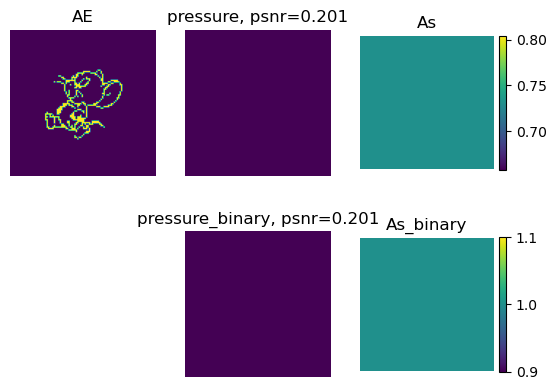

loss =  0.5905557870864868 psnr= 2.287390530594653
loss =  0.07036171108484268 psnr= 11.526635980965356
loss =  0.04642115533351898 psnr= 13.33284031568345
loss =  0.043029751628637314 psnr= 13.662311303147181
loss =  0.04245119169354439 psnr= 13.721100666822641
loss =  0.04245835915207863 psnr= 13.72036797575409
loss =  0.04260038584470749 psnr= 13.705864808314324
loss =  0.04276280850172043 psnr= 13.68933813463183
loss =  0.04291438311338425 psnr= 13.673971895773466
loss =  0.043047744780778885 psnr= 13.66049596077039
loss =  0.04316279664635658 psnr= 13.648903687273544
loss =  0.04326152056455612 psnr= 13.638982217546403
loss =  0.043346256017684937 psnr= 13.630484135025455
loss =  0.043419208377599716 psnr= 13.623180745163033
loss =  0.043482258915901184 psnr= 13.616879206119254
loss =  0.043536972254514694 psnr= 13.61141779003836
loss =  0.04358464851975441 psnr= 13.606664406068617
loss =  0.04362635686993599 psnr= 13.602510104157371
loss =  0.04366297647356987 psnr= 13.5988669640

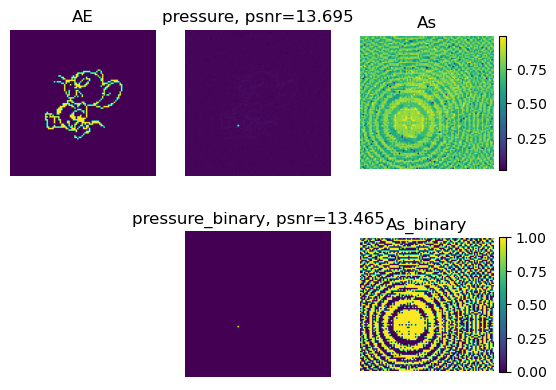

loss =  0.042697787284851074 psnr= 13.695946598103326
loss =  0.042689912021160126 psnr= 13.6967478279181
loss =  0.0426819734275341 psnr= 13.697554794939016
loss =  0.042673975229263306 psnr= 13.69836905522904
loss =  0.042665913701057434 psnr= 13.69918968095151
loss =  0.04265778884291649 psnr= 13.700016675686504
loss =  0.04264959692955017 psnr= 13.700850664555322
loss =  0.04264133796095848 psnr= 13.701691962373811
loss =  0.04263301566243172 psnr= 13.702539329851845
loss =  0.04262462630867958 psnr= 13.703394014262775
loss =  0.04261616989970207 psnr= 13.704256019894647
loss =  0.04260764271020889 psnr= 13.705124728950345
loss =  0.04259904846549034 psnr= 13.706001078792909
loss =  0.04259037971496582 psnr= 13.706884762825464
loss =  0.04258164018392563 psnr= 13.707776096741643
loss =  0.042572833597660065 psnr= 13.708674462582875
loss =  0.042563945055007935 psnr= 13.709580798819513
loss =  0.04255499318242073 psnr= 13.710495110403691
loss =  0.04254595935344696 psnr= 13.71141677

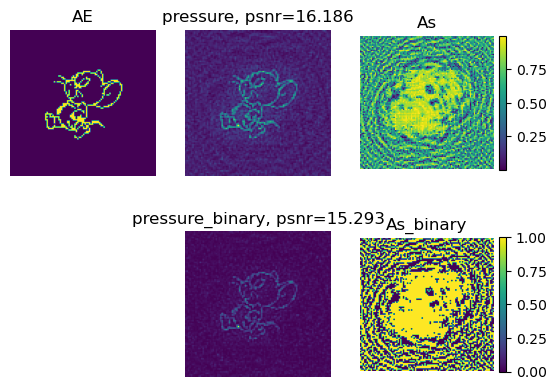

loss =  0.02402499131858349 psnr= 16.193367691572522
loss =  0.02398407831788063 psnr= 16.200769819931885
loss =  0.023943258449435234 psnr= 16.20816742618697
loss =  0.02390252612531185 psnr= 16.215561851866397
loss =  0.023861892521381378 psnr= 16.222951115185605
loss =  0.02382134459912777 psnr= 16.230336837407478
loss =  0.02378089353442192 psnr= 16.23771842168256
loss =  0.023740535601973534 psnr= 16.245095267208974
loss =  0.02370026521384716 psnr= 16.252467608048846
loss =  0.023660091683268547 psnr= 16.259835960071808
loss =  0.023620007559657097 psnr= 16.26719972054117
loss =  0.023580022156238556 psnr= 16.27455828274743
loss =  0.023540128022432327 psnr= 16.28191159902056
loss =  0.023500332608819008 psnr= 16.28925990349984
loss =  0.023460628464818 psnr= 16.296603714519826
loss =  0.023421023041009903 psnr= 16.30394129051885
loss =  0.023381514474749565 psnr= 16.31127371249836
loss =  0.023342102766036987 psnr= 16.31860008163431
loss =  0.02330278605222702 psnr= 16.325921768

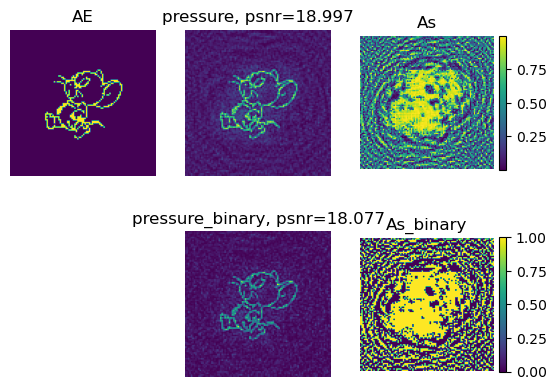

loss =  0.012585724703967571 psnr= 19.001217479846684
loss =  0.012574354186654091 psnr= 19.005143245643108
loss =  0.012563011609017849 psnr= 19.00906254107246
loss =  0.012551693245768547 psnr= 19.0129766653001
loss =  0.012540396302938461 psnr= 19.01688771488887
loss =  0.01252912636846304 psnr= 19.020791975957863
loss =  0.012517886236310005 psnr= 19.024689956401453
loss =  0.012506665661931038 psnr= 19.02858455038152
loss =  0.012495473027229309 psnr= 19.032472828786346
loss =  0.012484307400882244 psnr= 19.036355833131008
loss =  0.01247316412627697 psnr= 19.040233546141742
loss =  0.012462052516639233 psnr= 19.044104355253292
loss =  0.012450959533452988 psnr= 19.047972230645748
loss =  0.01243988610804081 psnr= 19.051835829631802
loss =  0.012428851798176765 psnr= 19.055689539334182
loss =  0.012417836114764214 psnr= 19.05954080148075
loss =  0.01240683626383543 psnr= 19.063389606518854
loss =  0.012395872734487057 psnr= 19.067228995101598
loss =  0.012384934350848198 psnr= 19.

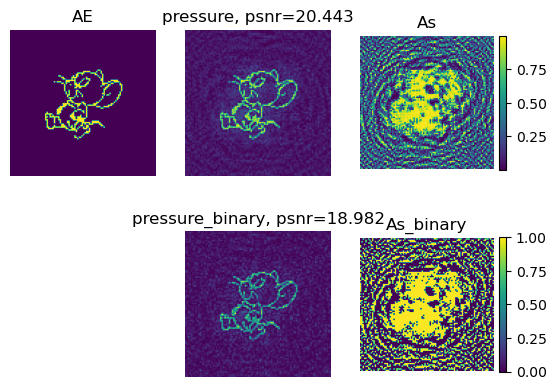

loss =  0.009024819359183311 psnr= 20.445614906367272
loss =  0.009020404890179634 psnr= 20.447739718518157
loss =  0.009016001597046852 psnr= 20.449860425715602
loss =  0.00901161227375269 psnr= 20.45197481534568
loss =  0.009007223881781101 psnr= 20.454091338463172
loss =  0.009002849459648132 psnr= 20.45620042864912
loss =  0.008998478762805462 psnr= 20.458309438927845
loss =  0.008994104340672493 psnr= 20.46042094746571
loss =  0.008989757858216763 psnr= 20.462519477215857
loss =  0.00898540299385786 psnr= 20.464624552782652
loss =  0.008981072343885899 psnr= 20.466717736564544
loss =  0.008976716548204422 psnr= 20.468824479443178
loss =  0.008972389623522758 psnr= 20.470919319656655
loss =  0.00896806176751852 psnr= 20.473014062412492
loss =  0.008963746950030327 psnr= 20.475104271339863
loss =  0.0089594516903162 psnr= 20.477185501535054
loss =  0.008955142460763454 psnr= 20.47927512957425
loss =  0.008950846269726753 psnr= 20.48135873014961
loss =  0.008946560323238373 psnr= 20.

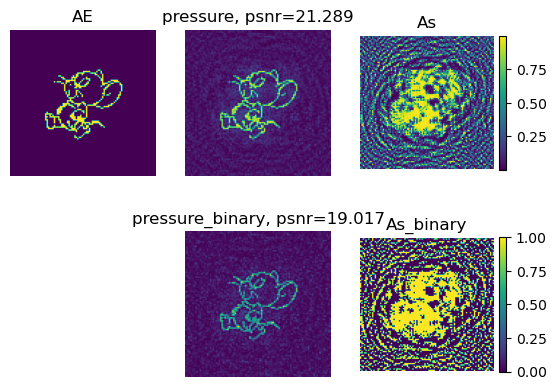

loss =  0.0074302032589912415 psnr= 21.289993063102422
loss =  0.007427964825183153 psnr= 21.291301639937636
loss =  0.007425709627568722 psnr= 21.292619981517195
loss =  0.007423465605825186 psnr= 21.29393292096438
loss =  0.0074211610481143 psnr= 21.29528152927321
loss =  0.007418863009661436 psnr= 21.29662609030326
loss =  0.007416597101837397 psnr= 21.297953197485363
loss =  0.0074143316596746445 psnr= 21.299279816542164
loss =  0.007412056904286146 psnr= 21.300612652331395
loss =  0.007409737445414066 psnr= 21.301972280175498
loss =  0.00740748131647706 psnr= 21.303293865403955
loss =  0.007405216805636883 psnr= 21.304622117102777
loss =  0.007402940187603235 psnr= 21.30595748884655
loss =  0.00740067008882761 psnr= 21.30728968958209
loss =  0.0073984283953905106 psnr= 21.30860528067151
loss =  0.007396196015179157 psnr= 21.309915894554212
loss =  0.007393971085548401 psnr= 21.311221974724965
loss =  0.007391763385385275 psnr= 21.31251903440927
loss =  0.007389486767351627 psnr= 2

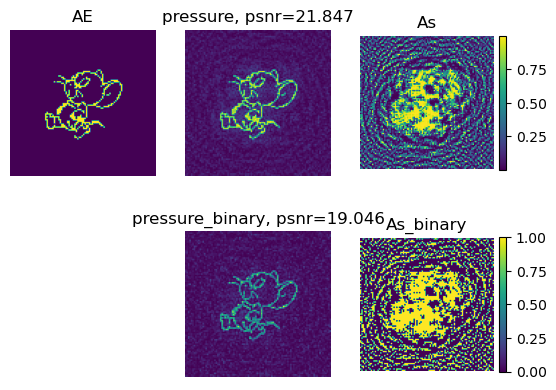

loss =  0.006533718667924404 psnr= 21.848395559541203
loss =  0.006532431114464998 psnr= 21.8492511615646
loss =  0.006531343795359135 psnr= 21.849975030046277
loss =  0.006529559381306171 psnr= 21.851161278627256
loss =  0.006528169848024845 psnr= 21.85208543756026
loss =  0.006526939570903778 psnr= 21.85290420060749
loss =  0.006525528151541948 psnr= 21.853843455563645
loss =  0.006524267606437206 psnr= 21.85468235657492
loss =  0.006522847805172205 psnr= 21.855627075901456
loss =  0.0065215155482292175 psnr= 21.85651458818471
loss =  0.006520128808915615 psnr= 21.85743887073972
loss =  0.006518720183521509 psnr= 21.8583760572899
loss =  0.006517252419143915 psnr= 21.859354118332096
loss =  0.006515795364975929 psnr= 21.860325280422597
loss =  0.006514379754662514 psnr= 21.861268685037516
loss =  0.00651297764852643 psnr= 21.86220415480257
loss =  0.006511511281132698 psnr= 21.86318155187596
loss =  0.0065101501531898975 psnr= 21.864089949897686
loss =  0.006508723367005587 psnr= 21.

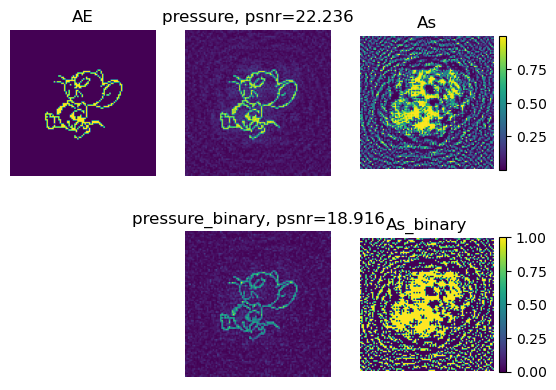

loss =  0.005974534898996353 psnr= 22.236958911881
loss =  0.005973739083856344 psnr= 22.237537385433438
loss =  0.005973075050860643 psnr= 22.238020245224114
loss =  0.005972708575427532 psnr= 22.23828652057191
loss =  0.005971735343337059 psnr= 22.23899417117652
loss =  0.005970821715891361 psnr= 22.23965892961299
loss =  0.005969874560832977 psnr= 22.240348765681468
loss =  0.00596911134198308 psnr= 22.2409029893155
loss =  0.005968105513602495 psnr= 22.241635216908
loss =  0.005966906901448965 psnr= 22.242507222855433
loss =  0.005965961143374443 psnr= 22.24319584537831
loss =  0.005964897572994232 psnr= 22.24397012076988
loss =  0.005964022595435381 psnr= 22.244607307428417
loss =  0.005962918978184462 psnr= 22.245410729168306
loss =  0.005961955059319735 psnr= 22.24611259467796
loss =  0.00596096646040678 psnr= 22.246833194573917
loss =  0.00596002209931612 psnr= 22.247521669516797
loss =  0.005959106609225273 psnr= 22.248188568643627
loss =  0.005958124529570341 psnr= 22.2489039

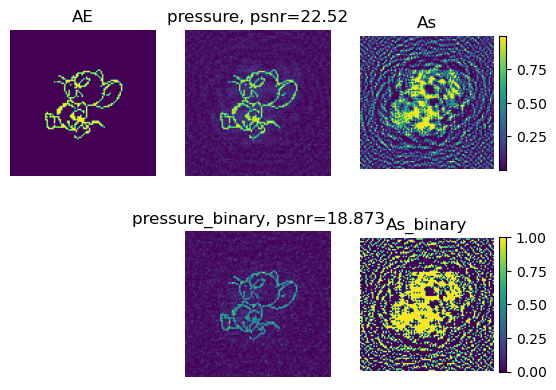

loss =  0.005597216542810202 psnr= 22.52027960044911
loss =  0.00559663213789463 psnr= 22.520732483871903
loss =  0.005595974158495665 psnr= 22.52124284832389
loss =  0.005595840513706207 psnr= 22.52134676398057
loss =  0.005594503600150347 psnr= 22.522384872802945
loss =  0.005593869835138321 psnr= 22.52287677312156
loss =  0.005593322683125734 psnr= 22.523301492868733
loss =  0.005592768080532551 psnr= 22.523731882373404
loss =  0.005592248402535915 psnr= 22.524135355727537
loss =  0.00559169240295887 psnr= 22.524567309276353
loss =  0.0055909897200763226 psnr= 22.525113089801515
loss =  0.005590246059000492 psnr= 22.525690648880378
loss =  0.00558948190882802 psnr= 22.526284290150024
loss =  0.00558878667652607 psnr= 22.526824357837633
loss =  0.005588245578110218 psnr= 22.52724531336569
loss =  0.0055881948210299015 psnr= 22.527284150051194
loss =  0.005590429063886404 psnr= 22.52554840041848
loss =  0.005587184336036444 psnr= 22.528070148757877
loss =  0.005586834158748388 psnr= 2

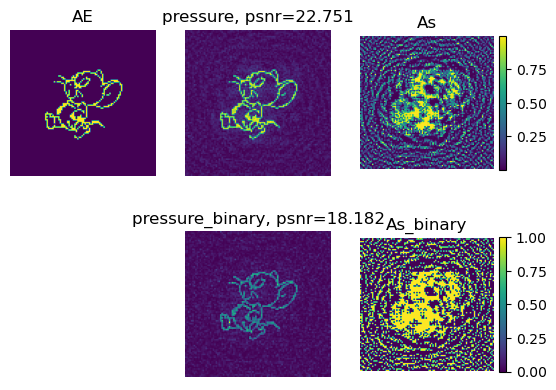

loss =  0.00530649721622467 psnr= 22.751920612152997
loss =  0.005306700710207224 psnr= 22.75175452357056
loss =  0.0053068241104483604 psnr= 22.751653374989566
loss =  0.005310205277055502 psnr= 22.748886751064777
loss =  0.005305236205458641 psnr= 22.752952251909257
loss =  0.005305913742631674 psnr= 22.752398308330356
loss =  0.005307475104928017 psnr= 22.751120822859853
loss =  0.0053077093325555325 psnr= 22.750928545756928
loss =  0.005309196654707193 psnr= 22.749712028563238
loss =  0.005309141241014004 psnr= 22.749756963106435
loss =  0.005309828091412783 psnr= 22.74919531472969
loss =  0.005309324711561203 psnr= 22.749606871067478
loss =  0.005309219937771559 psnr= 22.749692681889204
loss =  0.005308160558342934 psnr= 22.75055931019128
loss =  0.005307199899107218 psnr= 22.75134526096005
loss =  0.005306036677211523 psnr= 22.752297456984106
loss =  0.005304750055074692 psnr= 22.7533504229843
loss =  0.0053034196607768536 psnr= 22.75444019308545
loss =  0.005302109755575657 psnr

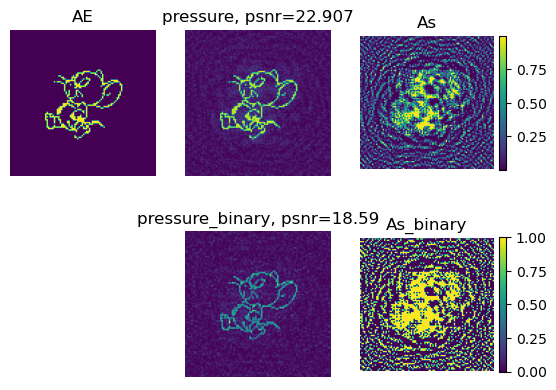

In [113]:
uniform_phs = torch.zeros(100,100)
amplitude = torch.ones(100,100,requires_grad=True)
# amplitude = torch.tensor(amplitude, requires_grad=True, dtype=torch.float32)
image_number = '6'
in_dir = 'C:\\Users\\DELL\\Desktop\\DiffBAOH/input_image/'
target = tiff.imread(in_dir + 'test_image_' + image_number + '_amp.tiff')
target = torch.tensor(target, dtype=torch.float32, requires_grad=False)

criter_mse = torch.nn.MSELoss()
criter_mae = torch.nn.L1Loss()


    # loss = torch.mean(torch.abs(Ac-target))
optimizer = optim.Adam([amplitude], lr=0.1)    
for i in range(5001):
    
    optimizer.zero_grad()  # 清除之前的梯度
    
    if i>5555555550:  #sign(amplitude) 0 or 1
        amplitude_01 = BinarySignGradient.apply(amplitude)
    else:         #sigmoid(amplitude)  0 to 1
        amplitude_01 = torch.sigmoid(amplitude)

    Ac_recon,Pc = ASM(d=20e-3, Source_PhsHolo=uniform_phs, Source_AmpHolo=amplitude_01, Lam=6.4e-4, fs=1e6/320)
        
    loss_mse = criter_mse(Ac_recon,target)
    loss_mse.backward()  # 计算梯度
    
    psnr = calculate_psnr(Ac_recon.detach().numpy(),target.detach().numpy())

    # print('loss = ', loss_mse)
    print('loss = ', loss_mse.item(),'psnr=',psnr)
    
    optimizer.step()  # 更新参数
    
    
           
    if i % 500 == 0:
        amp_binary = torch.where(amplitude_01>torch.mean(amplitude_01),1.0,0.0)
        # AS_scaled = (amplitude_01.detach().numpy()* 255).astype(np.uint8) 
        # ret2,amp_binary = cv2.threshold(AS_scaled,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # print("threshold >>", ret2)
        Ac_test,_ = ASM_numpy(d=20e-3, Source_PhsHolo=uniform_phs.numpy(), Source_AmpHolo=amp_binary, Lam=6.4e-4, fs=1e6/320)
        
        # amp_binary = torch.where(amplitude_01>0.5,1.0,0.0)
        
        # Ac_test,_ = ASM_numpy(d=20e-3, Source_PhsHolo=uniform_phs.numpy(), Source_AmpHolo=amp_binary.detach().numpy(), Lam=6.4e-4, fs=1e6/320)
        
        psnr1 = calculate_psnr(Ac_recon.detach().numpy(),target.numpy())
        psnr2 = calculate_psnr(Ac_test,target.numpy())
        psnr1 = np.round(psnr1,3)
        psnr2 = np.round(psnr2,3)
        print('PSNR nonbinary=',psnr1)
        print('PSNR binary=',psnr2)
        
        plt.subplot(231),plt.imshow(target.detach().numpy())
        plt.title('AE'), plt.axis('off')
        plt.subplot(232),plt.imshow(Ac_recon.detach().numpy())
        plt.title('pressure, psnr='+str(psnr1)), plt.axis('off')
        plt.subplot(233),plt.imshow(amplitude_01.detach().numpy())
        plt.title('As'), plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04) 
        
        plt.subplot(235),plt.imshow(Ac_test)
        plt.title('pressure_binary, psnr='+str(psnr2)), plt.axis('off')
        plt.subplot(236),plt.imshow(amp_binary)#.detach().numpy())
        plt.title('As_binary'), plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04) 
        
        
        plt.show()

    # if i % 100 == 0:
        
        
        
    #     print(loss_mse.item())
    #     amplitude_img = amplitude.detach().numpy()
    #     show_plt(amplitude_img)